<a href="https://colab.research.google.com/github/dan-a-iancu/airm/blob/master/ML_Bias/Bias_in_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction: Background and Data**

Our goal here is to understand how bias can arise in predictive Machine Learning models. We will rely on the contentious example of COMPAS, which is a proprietary software designed by Northpointe Inc. (now part of [Equivant](https://www.equivant.com/)) and used throughout the United States in bail and sentencing decisions. If you would like more background about COMPAS and the dispute initiated by journalists from ProPublica, check out these articles:
- https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing
- https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm

We are using the same dataset published by ProPublica of its [Github site](https://github.com/propublica/compas-analysis). The data has information on defendants from Broward County (Florida), and includes:
  *   `age`: The defendant's age
  *   `c_charge_degree`: The type of crime for which the most recent arrest was made. This has two potential values: **M** for **misdemeanor**, which is a less serious crime or **F** for **felony**, which is a more serious crime.
  *   `race`: The defendant's race; to simplify our task, we only kept records that were either **African American** or **Caucasian**.
  *   `sex`: Two values, **Male** or **Female**
  *   `priors_count`: The total number of prior convictions for the defendant
  *    `two_year_recid`: Whether the defendant actually reoffended within two years from the date of the scoring (1 for YES, 0 for NO). 

Similar to COMPAS, we will build machine learning algorithms that can predict **whether recidivism occurs within two years** (i.e., the field `two_year_recid`) based on the other information.

In [1]:
#@markdown Some preliminary work
import os
import sys
assert sys.version_info >= (3, 5)   # Python ≥3.5 is required
import urllib.request # for file downloading

import numpy as np   # numpy for numerical linear algebra
import pandas as pd  # pandas for managing dataframes

#import tensorflow as tf
#from tensorflow.keras import layers

import sklearn
assert sklearn.__version__ >= "0.20"  # Scikit-Learn version ≥0.20 required
import sklearn.metrics as metrics

# adjust reporting in pandas: max 15 rows and two-digit precision
#pd.options.display.max_rows = 15
pd.options.display.float_format = "{:,.2f}".format

# import matplotlib and pyplot: critical packages for plotting 
import matplotlib as mpl
import matplotlib.pyplot as plt
# Make sure Matplotlib runs inline, for nice figures
%matplotlib inline  
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# install the latest version of seaborn for nicer graphics
!pip install seaborn==0.12.2 &> /dev/null
import seaborn as sns

# install graphviz for visualizing decision trees
!pip install graphviz  &> /dev/null
import graphviz

# install pdpbox for partial dependency visualization
!pip install pdpbox &> /dev/null
from pdpbox import info_plots, pdp

# import useful utilities from Google colab
from google.colab import files

# Ignore useless some warnings
import warnings
warnings.filterwarnings("ignore")

# Create a function to save figures to a desired local folder
FIGURE_FOLDER = "Figures"
FIGURE_PATH = os.path.join(".",FIGURE_FOLDER)
os.makedirs(FIGURE_PATH, exist_ok=True)

# A function to append dummies for specified variables 
# returns the new dataframe and a dictionary with the categories for each categorical variable turned into a dummy
def append_dummies(data, columns):
  categories = {}  # the dictionary with categories
  data_with_dummies = data.copy() # the changed dataframe
  for col in columns:
    if col not in data.columns:
      print("WARNING. Column '{}' not among the columns in the dataframe. Skipping it.")
    elif (data[col].dtype!=int and data[col].dtype!=float):
      dummy_df = pd.get_dummies(data[col], prefix=col)
      categories[col] = list(dummy_df.columns)  # keep all the categories
      data_with_dummies = pd.merge( left=data_with_dummies, \
                                    right=dummy_df, \
                                   left_index=True, right_index=True,\
                                   how="inner", suffixes=("", "") )
  return data_with_dummies, categories
  
#markdown Download the data, process it following ProPublica's rules, and save it

##@markdown 1) Download data from ProPublica GitHub account and save it as a CSV file
url = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"  # full URL to the dataset
local_csv = "compas_data.csv"   # name of local file where you want to store the downloaded file
urllib.request.urlretrieve(url, local_csv)    # download from website and save it locally

# Read the data into a `pandas` DataFrame
raw_data = pd.read_csv(local_csv, index_col="id")

##@markdown 2) Filter the data using the same criteria as ProPublica
data = raw_data[ ["age", "c_charge_degree", "race", "age_cat", "score_text", "sex", "priors_count", \
              "days_b_screening_arrest", "decile_score", "is_recid", "two_year_recid", "c_jail_in", "c_jail_out"] ]

data = data.loc[ (data["days_b_screening_arrest"] <= 30) & (data["days_b_screening_arrest"] >= -30) & (data["is_recid"] != -1) & \
       (data["c_charge_degree"] != "O") & (data["score_text"] != "N/A") ]

##@markdown - In addition, we remove a few more columns to avoid confusion:
##@markdown  - **c_jail_in**, **c_jail_out**, **days_b_screening_arrest** : these are not useful in the prediction
##@markdown  - **is_recid** is a flag used by ProPublica, not needed for prediction
##@markdown  - **age** and **age_cat** are redundant; we keep **age**
data.drop(columns=["c_jail_in","c_jail_out", 'days_b_screening_arrest','age_cat', "is_recid"], inplace=True)
data.drop(columns=["score_text"], inplace=True)  # we also drop the text score for COMPAS
#data.drop(columns=["score_text","decile_score"], inplace=True)  # drop all the COMPAS scores

##@markdown - To focus our classroom discussion, we also remove all records where **race** is different than African-American or Caucasian
data = data.loc[ (data["race"]=='African-American') | (data["race"]=='Caucasian') ]
# #@markdown  - since the data has very few **Asian** and **Native American** records, we re-label these as **Other**
# #data.loc[ (data["race"]=='Asian') | (data["race"]=='Native American'), "race" ] = "Other"

#print("Done with all data processing tasks!")

##########################################################################
# #@markdown Download and prepare the data

##@markdown 1) Download data from ProPublica GitHub account and save it as a CSV file
url = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"  # full URL to the dataset
local_csv = "compas_data.csv"   # name of local file where you want to store the downloaded file
urllib.request.urlretrieve(url, local_csv)    # download from website and save it locally

# Read the data into a `pandas` DataFrame
raw_data = pd.read_csv(local_csv, index_col="id")

##@markdown 2) Filter the data using the same criteria as ProPublica
data = raw_data[ ["age", "c_charge_degree", "race", "age_cat", "score_text", "sex", "priors_count", \
              "days_b_screening_arrest", "decile_score", "is_recid", "two_year_recid", "c_jail_in", "c_jail_out"] ]

data = data.loc[ (data["days_b_screening_arrest"] <= 30) & (data["days_b_screening_arrest"] >= -30) & (data["is_recid"] != -1) & \
       (data["c_charge_degree"] != "O") & (data["score_text"] != "N/A") ]

##@markdown - In addition, we remove a few more columns to avoid confusion:
##@markdown  - **c_jail_in**, **c_jail_out**, **days_b_screening_arrest** : these are not useful in the prediction
##@markdown  - **is_recid** is a flag used by ProPublica, not needed for prediction
##@markdown  - **age** and **age_cat** are redundant; we keep **age**
data.drop(columns=["c_jail_in","c_jail_out", 'days_b_screening_arrest','age_cat', "is_recid"], inplace=True)

##@markdown - To focus our classroom discussion, we also remove all records where **race** is different than African-American or Caucasian
data = data.loc[ (data["race"]=='African-American') | (data["race"]=='Caucasian') ]
# #@markdown  - since the data has very few **Asian** and **Native American** records, we re-label these as **Other**
# #data.loc[ (data["race"]=='Asian') | (data["race"]=='Native American'), "race" ] = "Other"

# Drop COMPAS output
data_with_COMPAS = data.copy()
#data.drop(columns=["score_text"], inplace=True)  # we also drop the text score for COMPAS
data.drop(columns=["score_text","decile_score"], inplace=True)  # drop all the COMPAS scores

# print("Done with all data processing tasks!")

############################################################################
# #@markdown Define various functions to help with visualizations

# #@markdown - a function for simple visualizations of one or more features with histograms/boxplots/countplots
def visualize_features(all_data, features, figsize=(6,6), num_plot='histogram', \
                       num_bins='auto', num_cols=3):

    # calculate how many figures are needed
    num_figs = len(features)
    num_columns = (1 if num_figs==1 else num_cols)
    num_rows = int(np.ceil(num_figs/num_columns))
    
    # one large figure with a common title
    fig = plt.figure(figsize=(figsize[0]*num_columns,figsize[1]*num_rows))
    
    # title for plot
    title = ''

    for i in range(num_figs):

      # Create figure
      plt.subplot(num_rows,num_columns,i+1)
      ax1 = plt.gca()
      ax1.grid(alpha=.5, linewidth=1)

      if( (all_data[features[i]].dtype == 'float') or (all_data[features[i]].dtype == 'int') ):
        # numeric feature 
        
        # plot the feature according to the option
        if( num_plot == 'histogram'):
          #title = "Histogram of {}".format(features[i])
          sns.histplot(data = all_data[features[i]], bins=num_bins, color="skyblue", ax=ax1)

        elif( num_plot == 'boxplot' ):
          #title = "Boxplot of {}".format(features[i])
          sns.boxplot(data = all_data[features[i]], color="skyblue", ax=ax1)
        plt.tight_layout()

      else:
        # categorical feature
        sns.countplot(data = all_data, x=features[i], palette="Blues", ax=ax1)
        plt.tight_layout()

    plt.tight_layout()
    # determine the title
    #tar_ylabel = '{}'.format(target_name) if target_name else 'target'
    #fig.suptitle("Predicted value of {} as a function of feature(s).".format(tar_ylabel), fontsize=16, color=color1)

    plt.show()

#
#
# #@markdown - A function to visualize **average dependency** of one numeric feature as a function of two other features
def visualize_average_dependency(all_data_with_dummies, all_categories, \
                                 feature_y, feature_x1, feature_x2=None,\
                                 num_bins=10, uniform_bins=False, \
                                 show_outliers=False, figsize=(10,9), \
                                 extra_subtitle=""):
   
    # append to all categories a string for numeric categories
    all_feats = [feature_y, feature_x1]
    if feature_x2 != None:
      all_feats += [feature_x2]

    categ_for_infoplot = all_categories.copy()
    for feat_ in all_feats:
      if feat_ not in all_categories.keys():
        # just the names for numeric features
        categ_for_infoplot[feat_] = feat_

    if uniform_bins:
      grid_type='equal'
    else:
      grid_type='percentile'

    # do all the infoplots
    if feature_x2==None:
      # visualizing just two features, so a simple target_plot will do
      title = "Relation between '{}' and '{}'".format(feature_y,feature_x1)
      subtitle = "The '{}' is discretized on the x-axis into several potential (ranges of) values. You are seeing two plots:".format(feature_x1) +\
      "\n - the green bars are associated with the LEFT axis and show the count of data points where '{}' takes values in the corresponding range.".format(feature_x1) +\
      "\n - the line plot is associated with the RIGHT axis and shows the average value of '{}' for these data points.".format(feature_y)
      if len(extra_subtitle)>0:
        subtitle = subtitle + extra_subtitle

      fig, axes, summary_df = \
      info_plots.target_plot(df=all_data_with_dummies, \
                            feature=categ_for_infoplot[feature_x1], \
                            feature_name=feature_x1, \
                            target=categ_for_infoplot[feature_y],\
                            num_grid_points=num_bins, grid_type=grid_type, \
                            percentile_range=None, \
                            grid_range=None, cust_grid_points=None, \
                            show_percentile=False, \
                            show_outliers=show_outliers, endpoint=True, \
                            figsize=figsize, ncols=2, \
                            plot_params={"title" : title, "subtitle": subtitle})
    else:
      # plotting y as color-coded, as a function of x1 and x2
      print("Unsupported")  

##############################################################################
# #@markdown Define some useful functions to calculate predictive performance

# #@markdown Calculate and display useful performance metrics
def calculate_metrics_classification(y_true, y_pred, y_probas_pred, \
                                     positive_label_idx=1, \
                                     label_dataset=None, display=False, \
                                     store_other=True):
        
      # Classification task
      labels = [None, None]
      labels[positive_label_idx] = 1.0
      labels[1-positive_label_idx] = 0.0
      conf_mat = metrics.confusion_matrix(y_true, y_pred, labels=labels)

      # in SciKit learn, the rows are the true label, the columns are the predicted label   
      TP = conf_mat[positive_label_idx][positive_label_idx]
      TN = conf_mat[1-positive_label_idx][1-positive_label_idx]
      FP = conf_mat[1-positive_label_idx][positive_label_idx]
      FN = conf_mat[positive_label_idx][1-positive_label_idx]

      TPR = TP/(TP+FN) if (TP+FN>0) else "n/d"
      TNR = TN/(TN+FP) if (TN+FP>0) else "n/d"
      FPR = 1-TNR if TPR!="n/d" else "n/d"
      FNR = 1-TPR if TNR!="n/d" else "n/d"
      accuracy = metrics.accuracy_score(y_true, y_pred)
      precision = metrics.precision_score(y_true, y_pred)
      recall = metrics.recall_score(y_true, y_pred)
      sensitivity = TPR
      specificity = TNR
      roc_auc = metrics.roc_auc_score(y_true, y_probas_pred) if len(np.unique(y_true))>1 else "n/d"

      # the names of all the performance metrics
      names = ["True Positives (TP)", "True Negatives (TN)", \
              "False Positives (FP)", "False Negatives (FN)", \
              "True Positive Rate TPR=TP/(TP+FN)", \
              "True Negative Rate TNR=TN/(TN+FP)", \
              "False Positive Rate FPR=FP/(TN+FP)=1-TNR", \
              "False Negative Rate FNR=FN/(TP+FN)=1-TPR", \
              "Accuracy =(TP+TN)/(TP+FP+TN+FN)", \
              "Area Under ROC Curve (AUC)", \
              "Precision = TP/(TP+FP)", "Recall = TPR", \
              "Sensitivity = TPR", "Specificity = TNR"]

      values = [TP, TN, FP, FN, TPR, TNR, FPR, FNR, accuracy, roc_auc, \
                precision, recall, sensitivity, specificity  ]

      # also determine roc curve and precision_recall curve
      roc_curve = metrics.roc_curve(y_true, y_probas_pred)
      prec_recall_curve = metrics.precision_recall_curve(y_true, y_probas_pred)   

      if display:
        print("Results in the {} Set:".format(label_dataset if label_dataset!=None else "Data"))
        for i in range(len(names)):
          print('{:25s} : {:.2f}'.format(names[i],values[i]))

      # compile the results into a dictionary with metrics and plots
      results = {}    
      results["metrics_names"] = names
      results["metrics_values"] = values

      if store_other:
        results["others"] = {}
        results["others"]["conf_mat"] = conf_mat
        results["others"]["roc_curve"] = roc_curve
        results["others"]["prec_recall_curve"] = prec_recall_curve
      return results

#
#
#
# #@markdown A function to predict with each ML model for all samples in a dataset
def predict_all_methods_full_dataset(all_models, X_data, y_data, \
                                     dataset="Dataset", store_df=False):

      # we will store the results in a dictionary
      results = {}      # predictions/results for each sample

      # predict with each method
      for model_name in all_models.keys():
        model = all_models[model_name]["model"] # pick the model

        y_hat = model.predict(X_data)  # predict for entire training set
        pos_label_idx = list(model.classes_).index(1)  # locate positive class (i.e., label 1)
        y_prob = model.predict_proba(X_data)[:,pos_label_idx]  # get probabilities of y=1

        # calculate summary performance
        summary = calculate_metrics_classification(y_data, y_hat, y_prob, \
                                                  pos_label_idx, \
                                                  label_dataset=dataset, display=False, \
                                                  store_other=False)

        # a dictionary with the results
        aux = {}
        aux["y_hat"] = y_hat
        aux["pos_label_idx"] = pos_label_idx
        aux["y_prob"] = y_prob
        aux["summary"] = summary

        # store the results in the models
        all_models[model_name][dataset] = aux

        # update the overall results dictionary
        results[model_name] = aux

        # store the dataframe with summary results as well, if desired
        if store_df :
          results[model_name]["summary_df"] = \
          pd.DataFrame( data={model_name : summary["metrics_values"]}, \
                       index=summary["metrics_names"], columns=[model_name] )

      # now aggregate results for all samples into a single dataframe, including the predictions and errors
      results["all_samples_df"] = None

      for model_name in all_models.keys():
        results["all_samples_df"] = \
        pd.concat( [ results["all_samples_df"], \
                    pd.DataFrame({'{}_probability'.format(model_name) : \
                                  results[model_name]["y_prob"], \
                                  '{}_prediction'.format(model_name) : \
                                  results[model_name]["y_hat"]}, \
                                 index=X_train.index)],\
                  axis=1)

      # and similarly join the summary performance metrics into a single dataframe
      df_index = results[model_name]["summary"]["metrics_names"]
      df_col_names = []
      df_values = {}
      for model_name in all_models.keys():
        vals = results[model_name]["summary"]["metrics_values"]
        df_col_names += [model_name]
        df_values[model_name] = vals
      results["summary_df"] = pd.DataFrame( data = df_values, index=df_index, columns=df_col_names )

      return results    

#
#
#
# #@markdown A function to predict with a specific ML model using different thresholds for a feature
def predict_different_thresholds(model_name, model, X_data, y_data, full_data_training, \
                                 feature,  y_thresh_dict, dataset="Dataset", \
                                 save_df=True):

    # recover all the feature values from the **original** data 
    # (we do this because there may be processing for training)
    feature_values = full_data_training[feature]

    if feature_values.dtype==int or feature_values.dtype==float:
      print("Error. Predicting with different thresholds only works for categorical for now.")
      return {}

    # get the unique values of the feature
    unique_vals = feature_values.unique()

    y_hat = model.predict(X_data)  # predict for entire training set
    pos_label_idx = list(model.classes_).index(1)  # locate positive class (i.e., label 1)
    y_prob = model.predict_proba(X_data)[:,pos_label_idx]  # get probabilities of y=1

    # figure out the values of y_predicted (potentially using different thresholds)
    if set(unique_vals).issubset(set(y_thresh_dict.keys())) :
      # all the values are proper keys
      for v in unique_vals:
        filter = (feature_values==v)
        y_hat[filter] = (y_prob[filter] >= y_thresh_dict[v])
    else:
      print("Specified keys for feature {} not sufficient".feature)
      return {}

    # we will store the results in a dictionary
    results = {}      # predictions/results for each sample

    # calculate summary performance
    summary = calculate_metrics_classification(y_true=y_data, \
                                               y_pred=y_hat, \
                                               y_probas_pred=y_prob, \
                                               positive_label_idx=pos_label_idx, \
                                               label_dataset=dataset, display=False, \
                                               store_other=False)

    # a dictionary with the results
    aux = {}
    aux["y_hat"] = y_hat
    aux["pos_label_idx"] = pos_label_idx
    aux["y_prob"] = y_prob
    aux["summary"] = summary
    aux["y_thresh_dict"] = y_thresh_dict

    # update the overall results dictionary
    results[model_name] = aux

    # store the dataframe with summary results within the model, if desired
    if save_df :
      results[model_name]["summary_df"] = \
      pd.DataFrame( data={model_name : summary["metrics_values"]}, \
                   index=summary["metrics_names"], columns=[model_name] )

    return results

#
#
#
# #@markdown A function to visualize a binary confusion matrix
def our_plot_confusion_matrix(y_true, y_pred, class_names=None, \
                              true_on_row=True, positive_first=True, \
                              prefix_title="", figsize=(8,6), ax=None, \
                              pref_xlabel=None, pref_ylabel=None):

    # This is inspired by a similar visualization created by Google Research 
    # figure out if positive label should be first or not
    num_labels = [1, 0] if positive_first else [0, 1]
    labels = ["Positives", "Negatives"] if positive_first else ["Negatives", "Positives"]
    positive_label_idx = 0 if positive_first else 1

    strings = np.asarray([['True {}'.format(labels[0]), 'False {}'.format(labels[1])], \
                          ['False {}'.format(labels[0]), 'True {}'.format(labels[1])]])

    # get the confusion matrix
    # in SciKit, ROWS = true condition, COLUMNS = predicted condition
    conf_mat = metrics.confusion_matrix(y_true, y_pred, labels=num_labels)

    # calculate the rates
    true_conditions = conf_mat.sum(axis=1)  # sum on a row, for the true conditions in each class
    conf_mat_rates = np.array([ [conf_mat[0,0]/true_conditions[0] if true_conditions[0] > 0 else "n/d", \
                        conf_mat[0,1]/true_conditions[0] if true_conditions[0] > 0 else "n/d"], \
                       [conf_mat[1,0]/true_conditions[1] if true_conditions[1] > 0 else "n/d", \
                        conf_mat[1,1]/true_conditions[1] if true_conditions[1] > 0 else "n/d"] 
                      ])

    # determine whether to switch the row/column based on the preference for displaying
    if true_on_row:
        # true condition on the row -- this is how it is now; just set up the x/y labels
        if pref_ylabel:
          ylabel = pref_ylabel
        else:
          ylabel='Ground truth'

        if pref_xlabel:
          xlabel = pref_xlabel
        else:
          xlabel='Prediction'
    else:
        # we need the true condition on the column, and the predicted on the row
        for var_ in [strings, conf_mat, conf_mat_rates]:
          var_[0,1], var_[1,0] = var_[1,0], var_[0,1]
        if pref_ylabel:
          ylabel = pref_ylabel
        else:
          ylabel='Prediction'

        if pref_xlabel:
          xlabel = pref_xlabel
        else:
          xlabel='Ground truth'

    # set up the names to use for each class when printing
    class_names = [ class_names[i] for i in num_labels ] if class_names!=None else\
    [str(i) for i in num_labels]

    df_cm = pd.DataFrame(
        conf_mat, index=class_names, columns=class_names, 
    )

    #sns.set_context("notebook", font_scale=1.25)
    ax = ax or plt.gca()
    ax.set_title(prefix_title + 'Confusion Matrix ')

    # Combine the numerical value with its description
    labels = (np.asarray(
        ["{0:g}\n{1}\n(Rate: {2:.2f}%)".format(value, string, rate*100) \
         for value, string, rate in zip(
             conf_mat.flatten(), strings.flatten(), conf_mat_rates.flatten())\
         ])).reshape(2, 2)

    heatmap = sns.heatmap(conf_mat_rates, annot=labels, fmt="", 
        linewidths=2.0, cmap=sns.color_palette("Blues"), ax=ax, \
        annot_kws={"fontsize":12}, xticklabels=class_names, \
        yticklabels=class_names);
    heatmap.yaxis.set_ticklabels(
        heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    heatmap.xaxis.set_ticklabels(
        heatmap.xaxis.get_ticklabels(), rotation=0, ha='right')
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    return 0

#
#
#
# #@markdown Function to evaluate predictive performance depending on a feature 
def evaluate_performance_with_feature_values(model_name, model, feature, X_data, \
                                             y_data, full_data_training, \
                                             results_full_data,\
                                             num_bins=3, \
                                             prefix_title="", class_names=None,\
                                             include_full_dataset_eval=True,\
                                             display_conf_mat=True,\
                                             display_roc_pr=True, plot_together=False,\
                                             ax_roc=None, ax_pr=None, figsize=(7,7),\
                                             pref_xlabel=None, pref_ylabel=None):

  # select the right model to use and the right column to use for summary results
  y_hat = results_full_data["y_hat"]
  y_prob = results_full_data["y_prob"]
  pos_index = results_full_data["pos_label_idx"]

  # recover all the feature values from the **original** data 
  # (we do this because there may be processing for training)
  feature_values = full_data_training[feature]

  if feature_values.dtype==int or feature_values.dtype==float:
    # if numeric feature - handle separately by discretizing
    print("{} is a numeric feature. Will discretize into {} bins.".format(feature,num_bins))
    feature_values, bins =  pd.cut(feature_values, bins=num_bins, retbins=True,\
                                   include_lowest=True, ordered=True)

  # get the unique values of the feature
  unique_vals = feature_values.unique()
      
  # a few plotting settings
  fontsize = 12  # font size for titles in plots

  if display_conf_mat :
    # display the confusion matrices
    num_figs = len(unique_vals) + (1 if include_full_dataset_eval else 0)   # calculate how many

    fig_cm = plt.figure(figsize=(figsize[0]*num_figs,figsize[1]))  # create a figure of the desired size
    
    # get all the axes for subplots
    axs_cm = fig_cm.subplots(1, num_figs)

    # plot the confusion matrix for entire data
    if include_full_dataset_eval:
        aux = our_plot_confusion_matrix(y_true=y_data, y_pred=y_hat,\
                                        class_names=class_names, \
                                        true_on_row=True, positive_first=True, \
                                        prefix_title="", \
                                        figsize=(fig_width,fig_height), ax=axs_cm[0],\
                                        pref_xlabel=pref_xlabel, \
                                        pref_ylabel=pref_ylabel)
        axs_cm[0].set_title(prefix_title + "Confusion Matrix with Entire Dataset",\
                            fontsize=fontsize)


  if display_roc_pr:
    # if we want to display the ROC / prec-recall curves

    # cmap = mpl.cm.get_cmap("Blues")
    cmap = mpl.cm.get_cmap("jet")

    if (plot_together==False) or (ax_roc==None) or (ax_pr==None):
        # cannot plot together
        plot_together = False
        roc_pr_fig = plt.figure(figsize=(figsize[0]*2,figsize[1]))  # create a figure of the desired size
        
        ax_roc, ax_pr = roc_pr_fig.subplots(1,2)

        # settings for the ROC curve
        # set the colors into different shades of blue
        ax_roc.set_prop_cycle('color',[cmap(i) for i in np.linspace(0, 1, 1+len(unique_vals))])
    
        # settings for the precision-recall curve
        # set the colors into different shades of blue
        ax_pr.set_prop_cycle('color',[cmap(i) for i in np.linspace(0, 1, 1+len(unique_vals))])

        # will not use any prefix for the labels in the legend
        label_prefix = ""
        linestyle = "-"
    else:
        # we will be plotting the ROC/prec-recall on top of existing plots
        label_prefix = prefix_title   # use prefix in the legend
        prefix_title = ""     # no prefix in the title
        linestyle = "--"
    
    metrics.plot_roc_curve(model, X_data, y_data, \
                           sample_weight=None, response_method='auto', \
                           name='{}Entire data'.format(label_prefix), ax=ax_roc,\
                           linestyle=linestyle)
    ax_roc.set_title("{}Comparison of ROC Curves for '{}'".format(prefix_title,feature),\
                     fontsize=fontsize)

    # plot precision-recall curve with full dataset
    metrics.plot_precision_recall_curve(model, X_data, y_data, \
                                        sample_weight=None, response_method='auto', \
                                        name='{}Entire data'.format(label_prefix), ax=ax_pr, \
                                        linestyle=linestyle)
    ax_pr.set_title("{}Comparison of Precision-Recall Curves for '{}'".\
                    format(prefix_title,feature),fontsize=fontsize)
  else:
    ax_roc = None
    ax_pr = None

  # go through each individual value for the feature and calculate metrics + do plots
  for i in range(len(unique_vals)):
    v = unique_vals[i]
    filter = (feature_values==v)  # filter for all samples with value v
    if (len(y_data[filter])):
      results_v = calculate_metrics_classification(y_true=y_data[filter], \
                                                   y_pred=y_hat[filter], \
                                                   y_probas_pred=y_prob[filter], \
                                                   positive_label_idx=pos_index, \
                                                   display=False)
            
      # copy the column with aggregate results on the entire dataset
      col_v_name = "{}={}".format(feature,v)

      # if needed, visualize the confusion matrix
      if display_conf_mat:
          plot_idx = (1 if include_full_dataset_eval else 0) + i

          # plot the confusion matrix with the correct feature
          aux = our_plot_confusion_matrix(y_true=y_data[filter], \
                                          y_pred=y_hat[filter],\
                                          class_names=class_names, \
                                          true_on_row=True, positive_first=True, \
                                          prefix_title="", \
                                          figsize=(fig_width,fig_height), \
                                          ax=axs_cm[plot_idx], pref_xlabel=pref_xlabel,\
                                          pref_ylabel=pref_ylabel)
          axs_cm[plot_idx].set_title(prefix_title + col_v_name,fontsize=fontsize)

      if display_roc_pr:
        # plot ROC curve with partial data
        label = "{}{}".format(label_prefix,col_v_name)
        metrics.plot_roc_curve(model, X_data[filter], y_data[filter], \
                              sample_weight=None, response_method='auto', \
                              name=label, ax=ax_roc,  linestyle=linestyle)

        # plot precision-recall curve with partial data
        metrics.plot_precision_recall_curve(model, X_data[filter], y_data[filter], \
                                            sample_weight=None, response_method='auto', \
                                            name=label, ax=ax_pr, linestyle=linestyle)
    else:
      print('Feature {} has no values equal to {}. Will omit that category.'.format(feature,v))

  return ;

_________________
# **1. Understand the Data**
*Explore the data using some of the visualizations below. We suggest expanding the hidden cells as needed to see the output.*

<font color=red>**Q: How would you characterize:**
 - **the relationship between recidivism (`two_year_recid`) and other features?**
 - **the relationship between race (`race`) and other features?**</font>

### Visualize each data field 

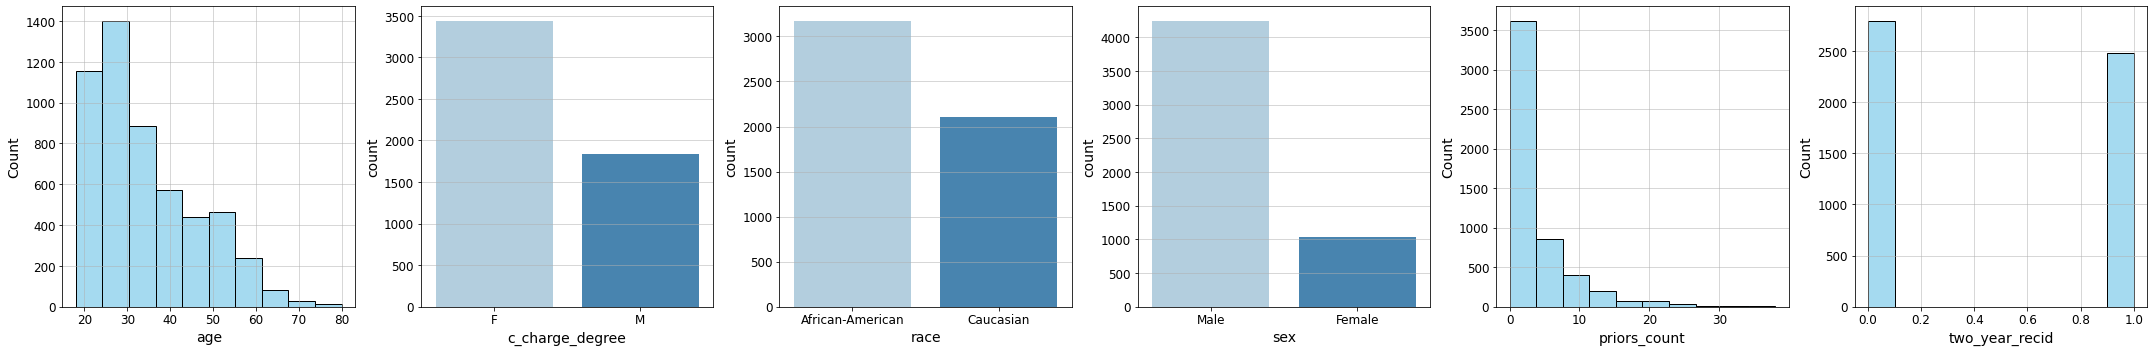

In [2]:
#@markdown **Build separate visualizations**

#@markdown Select which features to visualize (**"All"** will plot all the features, but may take a bit more time):
feature = "All" #@param ['All', 'age', 'c_charge_degree', 'race',  'sex', 'priors_count', 'two_year_recid']

if(feature=="All"):
  # all features except ocean proximity (which is categorical)
  feature = list(data.columns)
else:
  feature = [feature]

# #@markdown <br><br>**Feel free to customize some elements of the plot (leave as "Auto" if unsure)**

#@markdown Choose or type how many figures to display per row:
figures_per_row = "7" #@param ["Auto",3,4,5,6,7,10]{allow-input: true}
if figures_per_row=="Auto":
   figures_per_row=7
else:
   figures_per_row=np.int(figures_per_row)
#figures_per_row = 7

# #@markdown Choose or type how many bins to use for the histogram:
# num_bins = "Auto" #@param ["Auto",5,10,20,50,100]{allow-input: true}
num_bins=10

#@markdown Feel free to adjust the size of each figure:
figure_size = "5" #@param ["Auto",3,4,5,6,7,10]{allow-input: true}
if figure_size=="Auto":
   figure_size=5.0
else:
   figure_size=np.float(figure_size)
#figure_width = 5


# plot the feature(s)
visualize_features(all_data=data, features=feature, \
                   figsize=(figure_size,figure_size), num_plot="histogram", \
                   num_bins=num_bins, num_cols=figures_per_row)

### Relationship between recidivism (**two_year_recid**) and other data fields

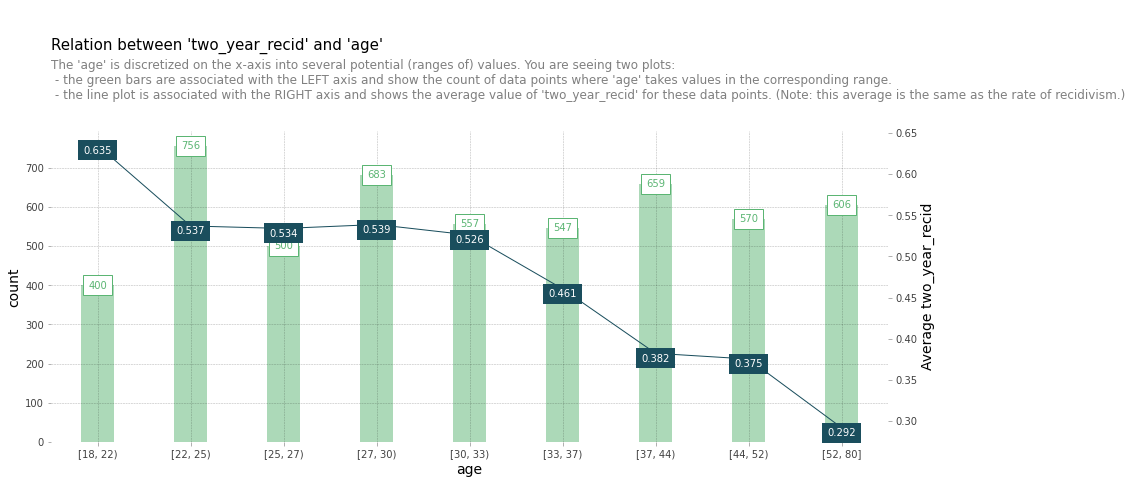

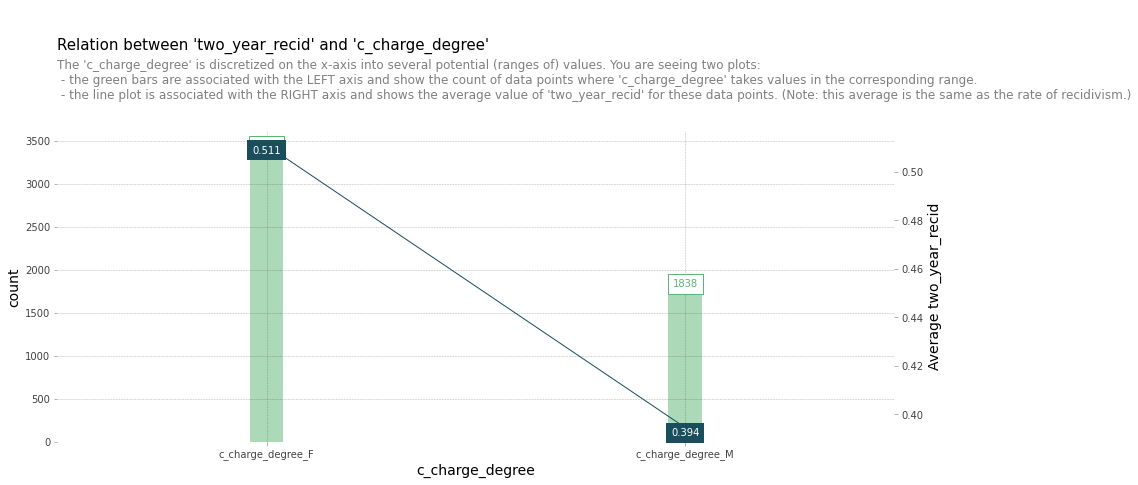

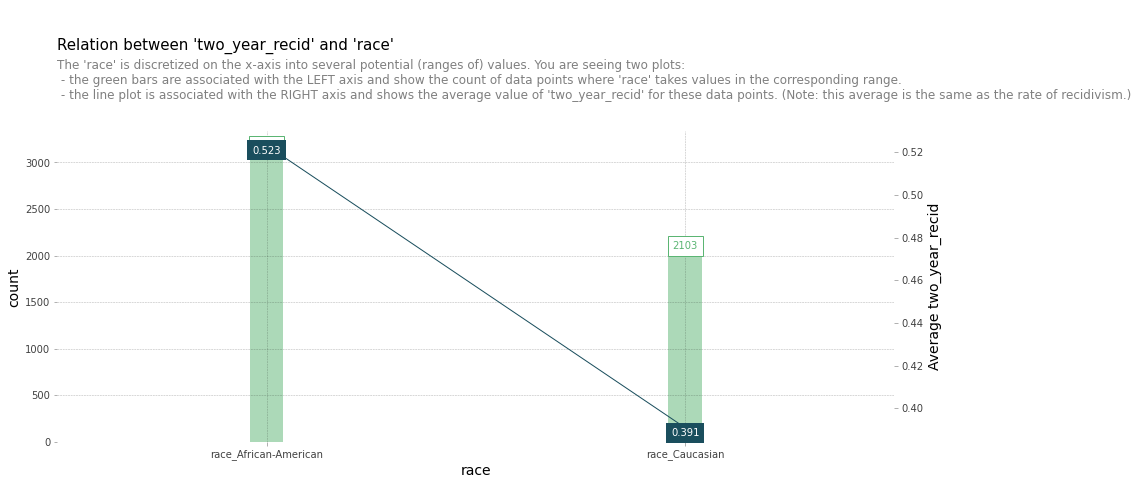

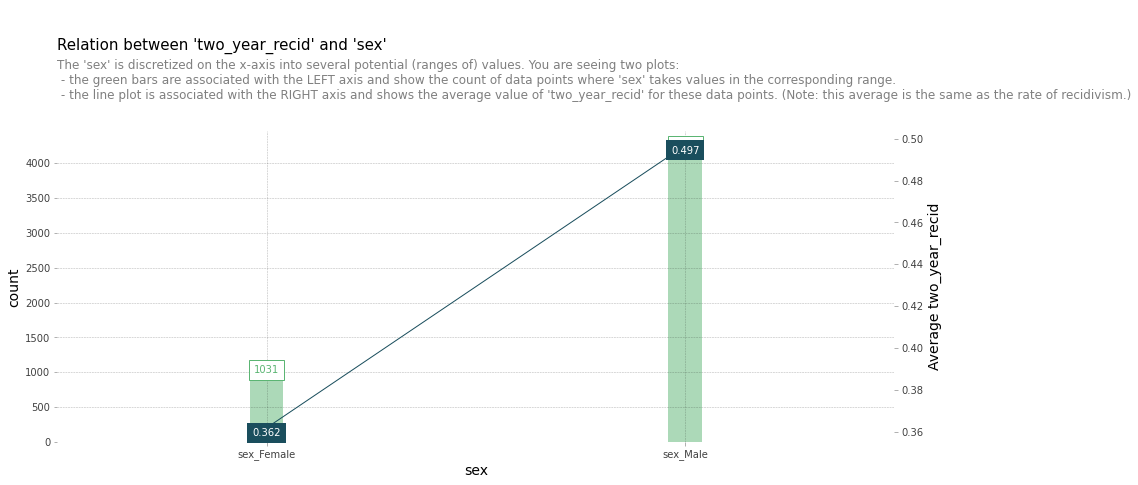

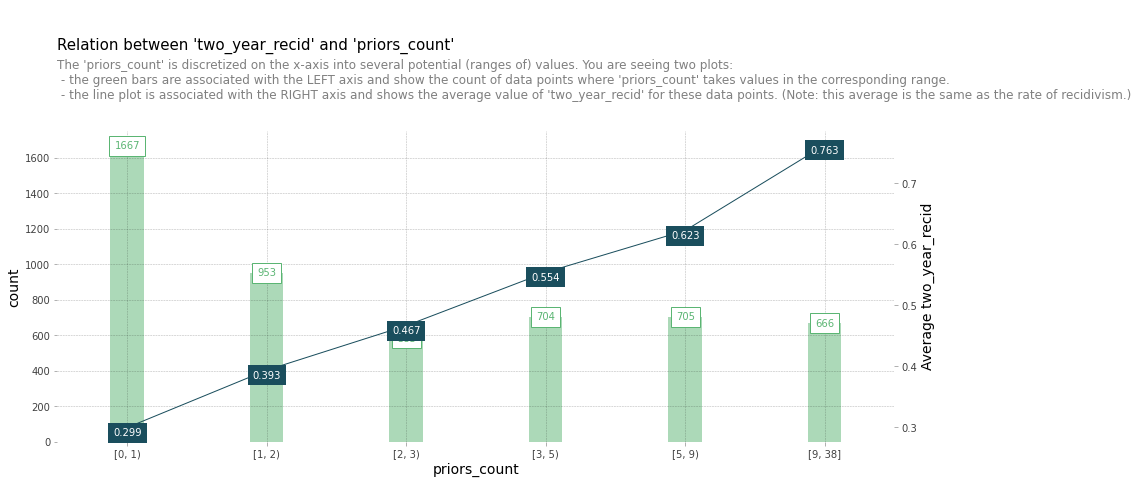

In [3]:
# append dummies and store categories for all data (useful for plotting routines)
data_with_dummies, data_categories = append_dummies(data, data.columns)

# #@markdown Select the **main feature/target** for which you want to visualize dependencies:
# main_feature = 'two_year_recid' #@param ['age', 'c_charge_degree', 'race', 'sex', 'priors_count', 'decile_score', 'two_year_recid']
main_feature = 'two_year_recid'

#@markdown Select one of the data fields (selecting **All** will display all dependencies):
feature = 'All' #@param ['age', 'c_charge_degree', 'race', 'sex', 'priors_count', 'two_year_recid', 'All']

# #@markdown (Optional) An additional numeric or categorical feature to visualize:
#feature_2 = "None" #@param ['None', 'age', 'c_charge_degree', 'race', 'sex', 'priors_count', 'two_year_recid']
feature_2 = "None"

# #@markdown (Optional) A categorical feature to use for breaking down into several sub-plots:
#breakdown_feature = "None" #@param ['None', 'c_charge_degree', 'race', 'sex']
breakdown_feature = "None"

# # @markdown <br>**Select the type of plot to see**
# # @markdown - **scatter** is the usual scatter plot you are familiar with
# # @markdown - **average_dependency** displays the average value of the **`main_feature`**
# # @markdown - **count** attempts to do a simple count plot
# # @markdown - **boxen** attempts to do a boxen-plot (more detailed version of a boxplot)
# plot_type = 'average_dependency' #@param ['average_dependency', 'scatter', 'count', 'boxen']
plot_type = 'average_dependency'

#@markdown Feel free to choose (or type) a scaling factor to adjust the size of each figure
# #@markdown General settings:
fig_scale = '1.0' #@param ['0.5', '0.75', '1.0', '1.25', '1.5', '2.0']{allow-input : true}
fig_width = '15'
fig_height = '8'

# #@markdown For an average dependency plot:
# #@markdown - **`num_bins`** : the number of bins to use when discretizing a numeric feature
# #@markdown - **`equal_probability`** : whether to use bins with roughly equal probability (unchecking this will generate bins with equal width)
# num_bins = '10' #@param ['Auto']{allow-input : true}
# equal_probability = True #@param {type:"boolean"}
num_bins = '10'
equal_probability = True

# set up parameters properly
if feature_2=="None":
  feature_2 = None

if breakdown_feature=="None":
  breakdown_feature = None

if fig_width=='Auto':
  fig_width=7.0
else:
  fig_width=np.float(fig_width)*np.float(fig_scale)

if fig_height=='Auto':
  fig_height=7.0
else:
  fig_height=np.float(fig_height)*np.float(fig_scale)

if num_bins=='Auto':
  num_bins=10
else:
  num_bins=np.int(num_bins)

extra_subtitle = " (Note: this average is the same as the rate of recidivism.)"

if feature=='All':
   for feature in data.columns:
       if feature!="two_year_recid":
          visualize_average_dependency(all_data_with_dummies=data_with_dummies,\
                                       all_categories=data_categories, \
                                       feature_y=main_feature, feature_x1=feature,\
                                       feature_x2=feature_2,num_bins=num_bins,\
                                       uniform_bins=(not equal_probability),\
                                       show_outliers=True,\
                                       figsize=(fig_width,fig_height),\
                                       extra_subtitle = extra_subtitle)
else:
    visualize_average_dependency(all_data_with_dummies=data_with_dummies,\
                                 all_categories=data_categories, \
                                 feature_y=main_feature, feature_x1=feature,\
                                 feature_x2=feature_2,num_bins=num_bins,\
                                 uniform_bins=(not equal_probability),\
                                 show_outliers=True,\
                                 figsize=(fig_width,fig_height),\
                                 extra_subtitle = extra_subtitle)

### Relationship between **race** and the other data fields

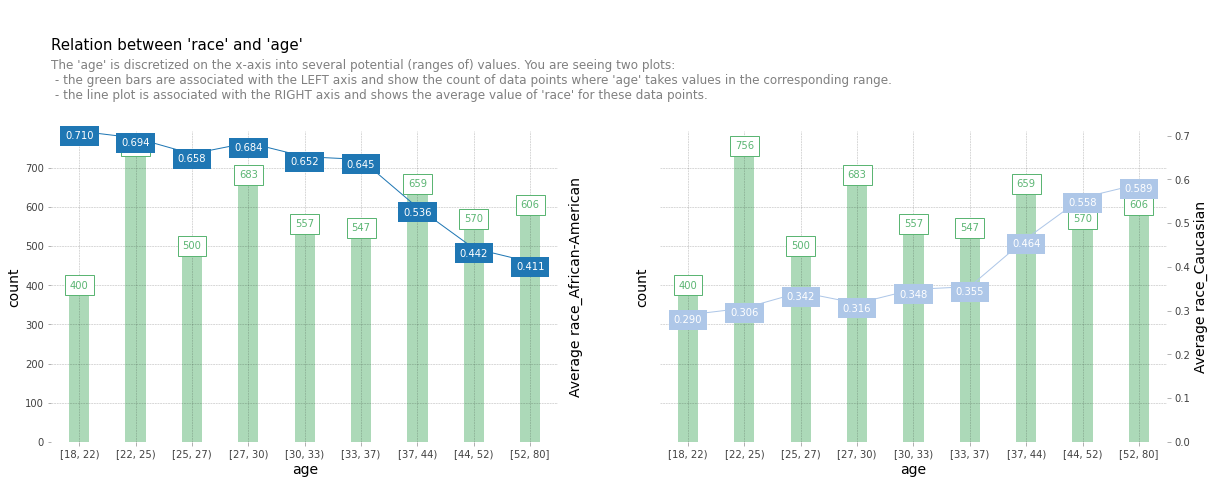

In [4]:
# #@markdown Select the **main feature/target** for which you want to visualize dependencies:
# main_feature = 'two_year_recid' #@param ['age', 'c_charge_degree', 'sex', 'priors_count', 'decile_score']
main_feature = 'race'

#@markdown Select one of the data fields (selecting **All** will display all dependencies):
feature = 'age' #@param ['age', 'c_charge_degree', 'sex', 'priors_count', 'All']

# #@markdown (Optional) An additional numeric or categorical feature to visualize:
#feature_2 = "None" #@param ['None', 'age', 'c_charge_degree', 'race', 'sex', 'priors_count', 'two_year_recid']
feature_2 = "None"

# #@markdown (Optional) A categorical feature to use for breaking down into several sub-plots:
#breakdown_feature = "None" #@param ['None', 'c_charge_degree', 'race', 'sex']
breakdown_feature = "race"

# # @markdown <br>**Select the type of plot to see**
# # @markdown - **scatter** is the usual scatter plot you are familiar with
# # @markdown - **average_dependency** displays the average value of the **`main_feature`**
# # @markdown - **count** attempts to do a simple count plot
# # @markdown - **boxen** attempts to do a boxen-plot (more detailed version of a boxplot)
# plot_type = 'average_dependency' #@param ['average_dependency', 'scatter', 'count', 'boxen']
plot_type = 'average_dependency'

# #@markdown **You can further customize some aspects of the plot**
# #@markdown General settings:
#fig_width = '30' #@param ['Auto']{allow-input : true}
# fig_height = '10' #@param ['Auto']{allow-input : true}
fig_width = '20'
fig_height = '8'

# #@markdown For an average dependency plot:
# #@markdown - **`num_bins`** : the number of bins to use when discretizing a numeric feature
# #@markdown - **`equal_probability`** : whether to use bins with roughly equal probability (unchecking this will generate bins with equal width)
# num_bins = '10' #@param ['Auto']{allow-input : true}
# equal_probability = True #@param {type:"boolean"}
num_bins = '10'
equal_probability = True

# set up parameters properly
if feature_2=="None":
  feature_2 = None

if breakdown_feature=="None":
  breakdown_feature = None

if fig_width=='Auto':
  fig_width=7.0
else:
  fig_width=np.float(fig_width)

if fig_height=='Auto':
  fig_height=7.0
else:
  fig_height=np.float(fig_height)

if num_bins=='Auto':
  num_bins=10
else:
  num_bins=np.int(num_bins)

all_relev_features = [f for f in data.columns if f not in ['race', 'two_year_recid']]

if feature=='All':
   for feature in all_relev_features:
     visualize_average_dependency(all_data_with_dummies=data_with_dummies,\
                                  all_categories=data_categories, \
                                  feature_y=main_feature, feature_x1=feature,\
                                  feature_x2=feature_2,num_bins=num_bins,\
                                  uniform_bins=(not equal_probability),\
                                  show_outliers=True,\
                                  figsize=(fig_width,fig_height))
else:
    visualize_average_dependency(all_data_with_dummies=data_with_dummies,\
                                 all_categories=data_categories, \
                                 feature_y=main_feature, feature_x1=feature,\
                                 feature_x2=feature_2,num_bins=num_bins,\
                                 uniform_bins=(not equal_probability),\
                                 show_outliers=True,\
                                 figsize=(fig_width,fig_height))

_____
# **2. Construct and Inspect Our Own Model for Bias**
Here, we will use a "White-Box" (i.e., Interpretable) Machine Learning Model, namely a **Decision Tree** with depth 3.

<font color=red>**Q: By inspecting the tree, would you say that it discriminates based on race?**

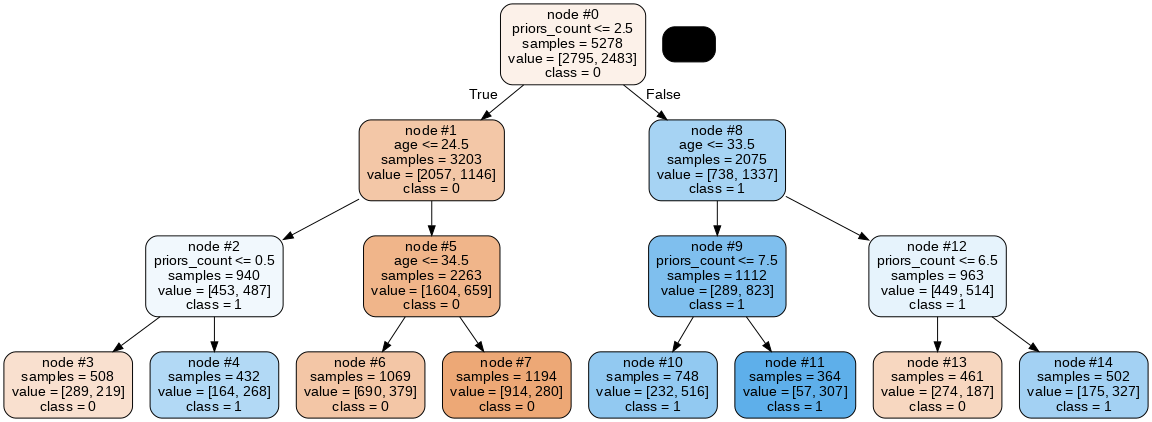

In [5]:
train_set = data
train_copy = train_set.copy()

#@markdown A **Decision Tree** model with depth 3.

# #@markdown Select **which features** to include in the training by ticking the box:
# #@markdown *(You can start with all the features and return later)*
# age = True #@param {type:"boolean"}
# #age_cat = True #@param {type:"boolean"}
# c_charge_degree = True #@param {type:"boolean"}
# race = True #@param {type:"boolean"}
# sex = True #@param {type:"boolean"}
# priors_count = True #@param {type:"boolean"}
age = True
c_charge_degree = True
race = True
sex = True
priors_count = True

# mapping between the variables and the names
selection = [age, c_charge_degree, race, sex, priors_count]

# all the names of features we could include 
all_features = ["age", "c_charge_degree", "race", "sex", "priors_count"]

target = "two_year_recid"
included_features = []  # list of names for all included features

X_train = None
#X_test = None

#print("Variables included in the model and any transformations done to them:")
for i in range(len(all_features)):
  if( selection[i] ):
      # feature was elected
      col = all_features[i]
      included_features += [col]
      if (train_set[col].dtype==int or train_set[col].dtype==float):
        # numeric variable
        X_train = pd.concat( [X_train, train_set[col]], axis=1 )
        #X_test = pd.concat( [X_test, test_set[col]], axis=1 )
        # print("{:20s} : including as is (numeric)".format(col))
      else:
        # categorical variable
        X_train = pd.concat( [X_train, pd.get_dummies(train_set[col], prefix=col)], axis=1 )
        #X_test = pd.concat( [X_test, pd.get_dummies(test_set[col], prefix=col)], axis=1 )
        #print("{:20s} : turning into dummies and removing last level '{}'".format(col,X_train.columns[-1][len(col)+1:]))
        #print("{:20s} : turning into dummies".format(col))
        #print("{:20s} : turning into dummies and removing last level '{}'".format(col,X_train.columns[-1]))
        #X_train.drop(columns=X_train.columns[-1], inplace=True)
        #X_test.drop(columns=X_test.columns[-1], inplace=True)

# list of names for all included features + target
included_features_with_target = included_features + [target]

# the target variables
y_train = train_set[target]
#y_test = test_set[target]

# have a look at the training data
X_train.head()

# initialize a dictionary to store all the models and their information
all_models = {}

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# #@markdown **Training**: select or type the **maximum depth** depth your tree is allowed to have (**`None`** will allow any depth):
# max_depth_to_train = "5" #@param [1, 2, 3, 4, 5, 6, "None"] {allow-input: true}
max_depth_to_train = "3"

if max_depth_to_train == "None":
  max_depth_to_train = None
else:
  max_depth_to_train = np.int(max_depth_to_train)

tree_model = DecisionTreeClassifier(criterion='gini', max_depth=max_depth_to_train, \
                                    random_state=123)
tree_model.fit(X_train, y_train)

# set up a small dictionary with the new model
all_models["tree"] = {}
all_models["tree"]["model"] = tree_model

# #@markdown **Visualization**: select or type the depth you want to see (**`None`** will try printing the full tree):
# max_depth_to_see = "5" #@param [1, 2, 3, 4, 5, 6, "None"] {allow-input: true}
max_depth_to_see = max_depth_to_train

if max_depth_to_see == "None":
  max_depth_to_see = None
else:
  max_depth_to_see = np.int(max_depth_to_see)

dot_data = tree.export_graphviz(tree_model, max_depth=max_depth_to_see, \
                                feature_names=X_train.columns, class_names=["0","1"],
                                label='all', filled=True, impurity=False, node_ids=True, \
                                rounded=True, proportion=False)
#graph = graphviz.Source(dot_data)
#graph

import pydotplus
pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.set_size('"12,12!"')

from IPython.display import Image
Image(pydot_graph.create_png())

To help interpret the tree above, note that each node has several pieces of information:
- A _node ID_ to make it easy to identify the node. E.g., _"node #0"_ is the root.
- A _logical condition_ that compares one of the features with a value. E.g., in node #0, we are comparing the value of `priors_count` with 2.5. The left (respectively, right) subtree has all the data points where that condition is true (respectively, false).
- _samples_ counts how many data points fall in the respective node. E.g., node #0 has 5,278 points.
- _value_ shows two values: the first is the number of data points (in that node) that have `two_year_recid` 0, and the second value is the number of data points that have `two_year_recid` 1 (the sum of the two values always equals _samples_). For instance, node #0 has 2,795 data points that have `two_year_recid` equal to 0 and 2,483 data points that have `two_year_recid` equal to 1.

Each node is color-coded in shades of **orange** and **blue**. The two colors correspond to the two possible values of `two_year_recid`: **orange** corresponds to 0, and **blue** corresponds to 1, so each node's color tells you the label for the majority of the data points in that node: orange nodes have more zeros, blue nodes have more ones. The **shade** tells you how dominant the label is: the deeper orange (respectively, blue) a node becomes, the larger the fraction of zeros (respectively, ones). 

**Predictions** are done by following all the conditions based on the features until a final leaf is reached. With classification problems, it is common to predict the **probability** of the target taking a value of 1, which is done by taking the **average** of the target variable for all the training samples in that leaf node. One can also obtain a prediction of the actual target **label** by taking **a majority vote** in the leaf node (which is the same as comparing the predicted probability with the threshold of 0.5).

### **Evaluate the predictive performance separately for African-Americans and Caucasians**
**<font color=red>Q: Based on this output, would you say the algorithm is biased?</font>**

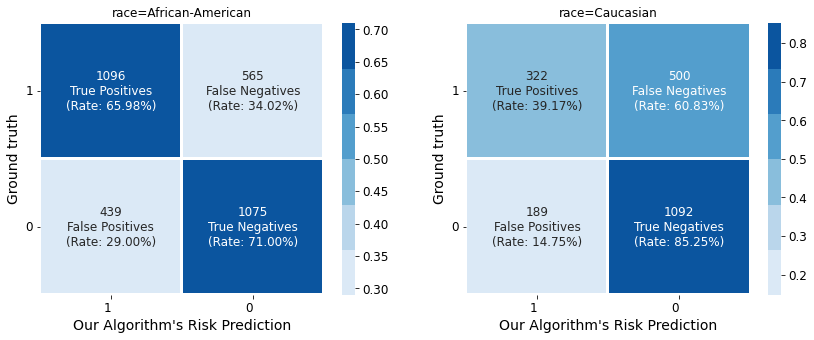

In [6]:
#@markdown Evaluate performance through the **confusion matrix** 

# **Let's predict in the entire <font color=red>training data</font> and display a few samples**
all_results = predict_all_methods_full_dataset(all_models, X_train, y_train, \
                                              dataset="train", store_df=True)

# join the results for all samples into a single dataframe, including the training data, predictions and errors
all_results["all_samples_and_data_df"] = pd.concat( [ train_copy[included_features_with_target].copy(), \
                                                 all_results["all_samples_df"] ], axis=1)

# #@markdown Select which performance metrics you want to see displayed. If you are not sure what these are, expand the previous section and read the brief description.
# display_all_performance_numbers = True #@param {type:"boolean"}
# display_confusion_matrix = True #@param {type:"boolean"}
# display_ROC_and_precision_recall_curves = False #@param {type:"boolean"}
display_all_performance_numbers = False
display_confusion_matrix = True
display_ROC_and_precision_recall_curves = False

# # @markdown <br>**You can further customize some aspects of the plot**
# # @markdown - **`fig_width`** : the width of each figure in inches (leave as **Auto** if unsure)
# # @markdown - **`fig_height`** : the height of each figure in inches (leave as **Auto** if unsure)
# fig_width = 'Auto' #@param ['Auto']{allow-input : true}
# fig_height = 'Auto' #@param ['Auto']{allow-input : true}
fig_width = 'Auto'
fig_height = 'Auto'

if fig_width=='Auto':
  fig_width=8.0
else:
  fig_width=np.float(fig_width)

if fig_height=='Auto':
  fig_height=6.0
else:
  fig_height=np.float(fig_height)

all_model_names = list(all_models.keys())
num_models = len(all_model_names)

# **Determine whether the predictive performance depends on the features**
model_name = "tree"
feature = "race"
num_bins = 3

# if the dictionary to store results by feature for that model does not exist, create it
if "by_feature" not in all_results[model_name].keys():
  all_results[model_name]["by_feature"] = {} 

evaluate_performance_with_feature_values(model_name=model_name, \
                                         model=all_models[model_name]["model"],\
                                         feature=feature, X_data=X_train, \
                                         y_data=y_train, 
                                         full_data_training=train_set, \
                                         results_full_data=all_results[model_name],\
                                         num_bins=num_bins, \
                                         prefix_title="", class_names=None,\
                                         include_full_dataset_eval=False,\
                                         display_conf_mat=display_confusion_matrix,\
                                         display_roc_pr=display_ROC_and_precision_recall_curves, \
                                         plot_together=False,\
                                         ax_roc=None, ax_pr=None,
                                         figsize=(7,5),\
                                         pref_xlabel="Our Algorithm's Risk Prediction")

<font color=black>To remember and interpret the output above, it is useful to think of a specific example that we may all be very familiar with, such as running a COVID test to detect if someone is actually infected. In this case, the **prediction** corresponds to the result of the test, and the **ground truth** corresponds to whether or not the person is infected with the virus. The following terminology is salient:</font><br>
> - use **true** when the prediction is correct (i.e., it matches the ground truth) and **false** when the prediction is wrong;
> - use **positive** when the prediction is $1$ (_e.g., the test result comes back "positive"_) and **negative** when the prediction is $0$ (_e.g., the test result comes back "negative"_).

This gives rise to the following four cases and associated terminology:
> * <font color=green>**True Positive (TP)**</font>: the test result is positive (i.e., model predicts $1$) and that matches the truth.
> * <font color=green>**True Negative (TN)**</font>: the test result is negative (i.e., model predicts $0$) and that matches the truth.
> * <font color=red>**False Positive (FP)**</font>: the test result is positive (i.e., model predicts $1$), but the ground truth is negative ($0$).
> * <font color=red>**False Negative (FN)**</font>: the test result is negative (i.e., model predicts $0$), but the ground truth is positive ($1$).

It is common to list these four values in a 2x2 matrix called a [**confusion matrix**](https://en.wikipedia.org/wiki/Confusion_matrix), which is a very concise way to summarize the performance of a binary classifier. And these can be used as a starting point to calculate other performance metrics, as follows:
- **True Positive Rate (TPR)** (also known as [**sensitivity**](https://en.wikipedia.org/wiki/Sensitivity_and_specificity)): the fraction of positive labels correctly identified as positive **TP/(TP+FN)**
- **True Negative Rate (TNR)** (also known as [**specificity**](https://en.wikipedia.org/wiki/Sensitivity_and_specificity)): the fraction of negative labels correctly identified as negative, **TN/(TN+FP)** 
- **False Positive Rate (FPR)**: the fraction of negative labels incorrectly identified as positive, **FP/(FP+TN) = 1 - TNR**
- **False Negative Rate (FNR)**: the fraction of positive labels incorrectly identified as negative, **FN/(FN+TP) = 1 - TPR**

# **3. Evaluate a Proprietary / "Black-Box" Model**

Here, we will evaluate the **COMPAS algorithm itself** based solely on its outputs, without any need to understand its inner workings. 

## Does **COMPAS** exhibit **gender** bias?

<font color=red>**Based on the two pieces of evidence below, would you say that COMPAS exhibits gender bias?**</font>

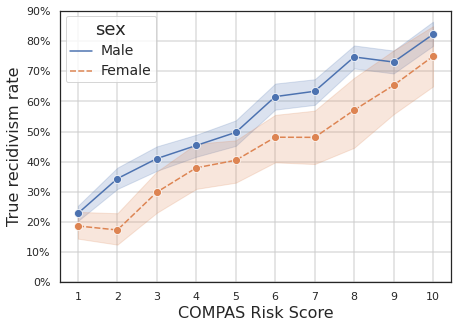

In [7]:
#@markdown <font color=blue>**Visualization #1.**</font> **True recidivism rate** for **men** and **women** as a function of the **risk score assigned by COMPAS**.
#@markdown <br>The center line indicates the mean score, and the band indicates a confidence interval.
#@markdown <br>_For instance, **men** (respectively, **women**) assigned a COMPAS score of 5 have a recidivism rate of roughly 49.75% (respectively, 40.50%)._

# get the full data, including the COMPAS score
data2 = data_with_COMPAS

# define a new column with a risk label: LOW for score <=4, otherwise HIGH
data2["risk_label"] = np.where(data2["decile_score"] <= 4, "LOW", "MED/HIGH")
data2["y_hat"] = np.where(data2["decile_score"] <= 4, 0, 1)

unique_scores = np.sort(data2["decile_score"].unique())

#sns.set_theme(style="darkgrid")
sns.set_theme(style="white")

fig = plt.figure(figsize=(7,5))

ax1 = plt.gca()
ax1.grid(alpha=.5, linewidth=2)

lnp = sns.lineplot(x="decile_score", y="two_year_recid", hue="sex", style="sex", \
             marker="o", markersize=8, 
             errorbar=('ci',90), err_style='band', data=data2, 
             legend=["Male","Female"], axes=ax1)

plt.xticks(unique_scores)
plt.yticks(np.arange(0,1,0.1),[ str(x)+"%" for x in np.arange(0,100,10)])
plt.xlabel("COMPAS Risk Score", fontsize=16)
plt.ylabel("True recidivism rate", fontsize=16)
#plt.title("Relationship between COMPAS risk score and true recidivism rate")
# for legend text
plt.setp(lnp.get_legend().get_texts(), fontsize='14') 
 
# for legend title
plt.setp(lnp.get_legend().get_title(), fontsize='18')

#lnp.legend(bbox_to_anchor= (1,1))
plt.show()

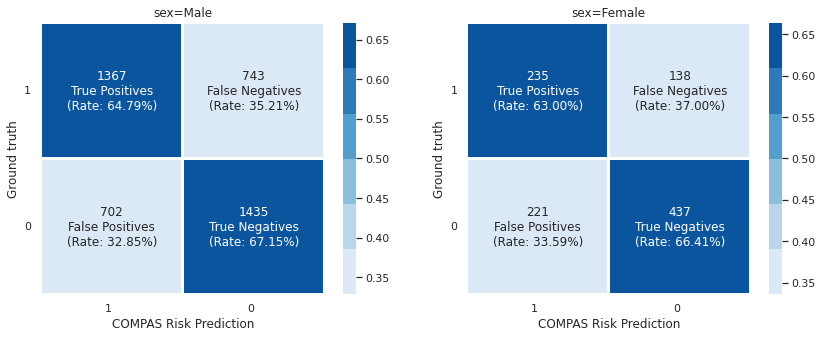

In [8]:
#@markdown <font color=blue>**Visualization #2.**</font> **Confusion matrices** obtained based on the COMPAS prediction, for each sex.<br>Here, defendants with COMPAS risk scores of 5 or above are labeled as **1 (i.e., high risk)**, and those with risk scores of 4 or below are labeled as **0 (low risk)**.
# create a dictionary with the right structure so we can use the same function to plot confusion matrices
results_hack = {}
results_hack["y_hat"] = np.array(data2["y_hat"])
results_hack["y_prob"] = np.array(data2["decile_score"]/10)
results_hack["pos_label_idx"] = 1
results_hack["summary"] = {}
#results_hack["summary_df"] = pd.DataFrame()

# plot the confusion matrices
evaluate_performance_with_feature_values(model_name="COMPAS", \
                                         model="",\
                                         feature="sex", X_data=data2, \
                                         y_data=data2["two_year_recid"], 
                                         full_data_training=data2, \
                                         results_full_data=results_hack,\
                                         num_bins=3, \
                                         prefix_title="", class_names=None,\
                                         include_full_dataset_eval=False,\
                                         display_conf_mat=True,\
                                         display_roc_pr=False, \
                                         plot_together=False,\
                                         ax_roc=None, ax_pr=None,
                                         figsize=(7,5),
                                         pref_xlabel="COMPAS Risk Prediction")

## Does **COMPAS** exhibit **racial** bias?

<font color=red>**Based on the two pieces of evidence below, would you say that COMPAS exhibits racial bias?**</font>

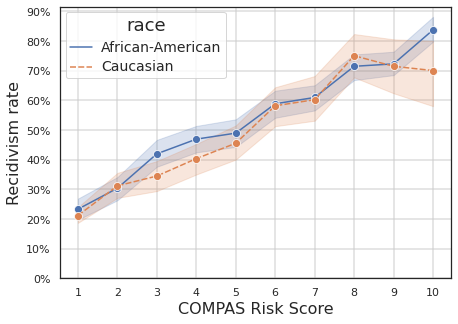

In [9]:
#@markdown <font color=blue>**Visualization #1.**</font> **Recidivism rates** for **African-Americans** and **Caucasians** as a function of the **risk score assigned by COMPAS**.
#@markdown <br>The center line indicates the mean score, and the band indicates a confidence interval.
#@markdown <br>_For instance, **African-Americans** (respectively, **Caucasians**) assigned a COMPAS score of 5 have a recidivism rate of roughly 48.9% (respectively, 45.5%)._

#sns.set_theme(style="darkgrid")
sns.set_theme(style="white")

fig = plt.figure(figsize=(7,5))
ax1 = plt.gca()
ax1.grid(alpha=.5, linewidth=2)

lnp = sns.lineplot(x="decile_score", y="two_year_recid", hue="race", style="race", \
             marker="o", markersize=8, linewidth=1.5,
             errorbar=('ci',90), err_style='band', data=data2, 
             legend=["African-Americans","Caucasian"], axes=ax1)

plt.xticks(unique_scores)
plt.yticks(np.arange(0,1,0.1),[ str(x)+"%" for x in np.arange(0,100,10)])
plt.xlabel("COMPAS Risk Score", fontsize=16)
plt.ylabel("Recidivism rate", fontsize=16)
#plt.title("Relationship between COMPAS risk score and true recidivism rate")
# for legend text
plt.setp(lnp.get_legend().get_texts(), fontsize='14') 
 
# for legend title
plt.setp(lnp.get_legend().get_title(), fontsize='18')

#lnp.legend(bbox_to_anchor= (1,1))
plt.show()

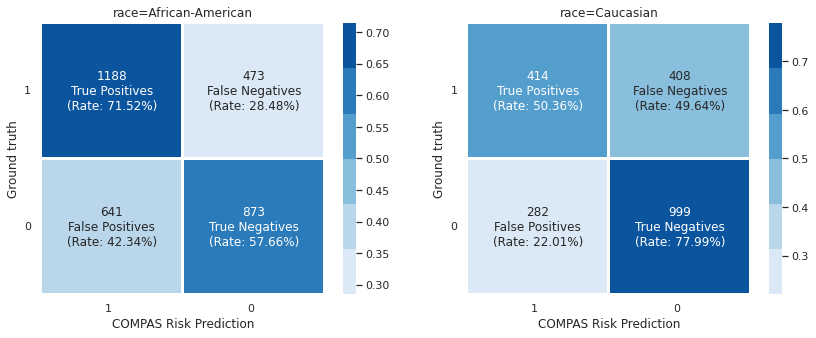

In [10]:
#@markdown <font color=blue>**Visualization #2.**</font> **Confusion matrices** obtained based on the COMPAS prediction, for each race.<br>Here, defendants with a COMPAS risk scores of 5 or above are labeled as 1 (i.e., high risk) whereas those with risk scores of 4 or below are labeled as 0 (low risk).
# create a dictionary with the right structure so we can use the same function to plot confusion matrices
results_hack = {}
results_hack["y_hat"] = np.array(data2["y_hat"])
results_hack["y_prob"] = np.array(data2["decile_score"]/10)
results_hack["pos_label_idx"] = 1
results_hack["summary"] = {}
#results_hack["summary_df"] = pd.DataFrame()

# plot the confusion matrices
evaluate_performance_with_feature_values(model_name="COMPAS", \
                                         model="",\
                                         feature="race", X_data=data2, \
                                         y_data=data2["two_year_recid"], 
                                         full_data_training=data2, \
                                         results_full_data=results_hack,\
                                         num_bins=3, \
                                         prefix_title="", class_names=None,\
                                         include_full_dataset_eval=False,\
                                         display_conf_mat=True,\
                                         display_roc_pr=False, \
                                         plot_together=False,\
                                         ax_roc=None, ax_pr=None,
                                         figsize=(7,5),
                                         pref_xlabel="COMPAS Risk Prediction")

In [11]:
#@markdown Download and prepare the data

##@markdown 1) Download data from ProPublica GitHub account and save it as a CSV file
url = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"  # full URL to the dataset
local_csv = "compas_data.csv"   # name of local file where you want to store the downloaded file
urllib.request.urlretrieve(url, local_csv)    # download from website and save it locally

# Read the data into a `pandas` DataFrame
raw_data = pd.read_csv(local_csv, index_col="id")

##@markdown 2) Filter the data using the same criteria as ProPublica
data = raw_data[ ["age", "c_charge_degree", "race", "age_cat", "score_text", "sex", "priors_count", \
              "days_b_screening_arrest", "decile_score", "is_recid", "two_year_recid", "c_jail_in", "c_jail_out"] ]

data = data.loc[ (data["days_b_screening_arrest"] <= 30) & (data["days_b_screening_arrest"] >= -30) & (data["is_recid"] != -1) & \
       (data["c_charge_degree"] != "O") & (data["score_text"] != "N/A") ]

##@markdown - In addition, we remove a few more columns to avoid confusion:
##@markdown  - **c_jail_in**, **c_jail_out**, **days_b_screening_arrest** : these are not useful in the prediction
##@markdown  - **is_recid** is a flag used by ProPublica, not needed for prediction
##@markdown  - **age** and **age_cat** are redundant; we keep **age**
data.drop(columns=["c_jail_in","c_jail_out", 'days_b_screening_arrest','age_cat', "is_recid"], inplace=True)

##@markdown - To focus our classroom discussion, we also remove all records where **race** is different than African-American or Caucasian
data = data.loc[ (data["race"]=='African-American') | (data["race"]=='Caucasian') ]
# #@markdown  - since the data has very few **Asian** and **Native American** records, we re-label these as **Other**
# #data.loc[ (data["race"]=='Asian') | (data["race"]=='Native American'), "race" ] = "Other"

# Drop COMPAS output
data_with_COMPAS = data.copy()
#data.drop(columns=["score_text"], inplace=True)  # we also drop the text score for COMPAS
data.drop(columns=["score_text","decile_score"], inplace=True)  # drop all the COMPAS scores

print("Done with all data processing tasks!")

Done with all data processing tasks!


In [12]:
#@markdown Define various functions to help with visualizations

# #@markdown - a function for simple visualizations of one or more features with histograms/boxplots/countplots
def visualize_features(all_data, features, figsize=(6,6), num_plot='histogram', \
                       num_bins='auto', num_cols=3):

    # calculate how many figures are needed
    num_figs = len(features)
    num_columns = (1 if num_figs==1 else num_cols)
    num_rows = int(np.ceil(num_figs/num_columns))
    
    # one large figure with a common title
    fig = plt.figure(figsize=(figsize[0]*num_columns,figsize[1]*num_rows))
    
    # title for plot
    title = ''

    for i in range(num_figs):

      # Create figure
      plt.subplot(num_rows,num_columns,i+1)
      ax1 = plt.gca()
      ax1.grid(alpha=.5, linewidth=1)

      if( (all_data[features[i]].dtype == 'float') or (all_data[features[i]].dtype == 'int') ):
        # numeric feature 
        
        # plot the feature according to the option
        if( num_plot == 'histogram'):
          #title = "Histogram of {}".format(features[i])
          sns.histplot(data = all_data[features[i]], bins=num_bins, color="skyblue", ax=ax1)

        elif( num_plot == 'boxplot' ):
          #title = "Boxplot of {}".format(features[i])
          sns.boxplot(data = all_data[features[i]], color="skyblue", ax=ax1)
        plt.tight_layout()

      else:
        # categorical feature
        sns.countplot(data = all_data, x=features[i], palette="Blues", ax=ax1)
        plt.tight_layout()

    plt.tight_layout()
    # determine the title
    #tar_ylabel = '{}'.format(target_name) if target_name else 'target'
    #fig.suptitle("Predicted value of {} as a function of feature(s).".format(tar_ylabel), fontsize=16, color=color1)

    plt.show()

#
#
# #@markdown - A function to visualize **average dependency** of one numeric feature as a function of two other features
def visualize_average_dependency(all_data_with_dummies, all_categories, \
                                 feature_y, feature_x1, feature_x2=None,\
                                 num_bins=10, uniform_bins=False, \
                                 show_outliers=False, figsize=(10,9), \
                                 extra_subtitle=""):
   
    # append to all categories a string for numeric categories
    all_feats = [feature_y, feature_x1]
    if feature_x2 != None:
      all_feats += [feature_x2]

    categ_for_infoplot = all_categories.copy()
    for feat_ in all_feats:
      if feat_ not in all_categories.keys():
        # just the names for numeric features
        categ_for_infoplot[feat_] = feat_

    if uniform_bins:
      grid_type='equal'
    else:
      grid_type='percentile'

    # do all the infoplots
    if feature_x2==None:
      # visualizing just two features, so a simple target_plot will do
      title = "Relation between '{}' and '{}'".format(feature_y,feature_x1)
      subtitle = "The '{}' is discretized on the x-axis into several potential (ranges of) values. You are seeing two plots:".format(feature_x1) +\
      "\n - the green bars are associated with the LEFT axis and show the count of data points where '{}' takes values in the corresponding range.".format(feature_x1) +\
      "\n - the line plot is associated with the RIGHT axis and shows the average value of '{}' for these data points.".format(feature_y)
      if len(extra_subtitle)>0:
        subtitle = subtitle + extra_subtitle

      fig, axes, summary_df = \
      info_plots.target_plot(df=all_data_with_dummies, \
                            feature=categ_for_infoplot[feature_x1], \
                            feature_name=feature_x1, \
                            target=categ_for_infoplot[feature_y],\
                            num_grid_points=num_bins, grid_type=grid_type, \
                            percentile_range=None, \
                            grid_range=None, cust_grid_points=None, \
                            show_percentile=False, \
                            show_outliers=show_outliers, endpoint=True, \
                            figsize=figsize, ncols=2, \
                            plot_params={"title" : title, "subtitle": subtitle})
    else:
      # plotting y as color-coded, as a function of x1 and x2
      print("Unsupported")  

In [13]:
#@markdown Define some useful functions to calculate predictive performance

# #@markdown Calculate and display useful performance metrics
def calculate_metrics_classification(y_true, y_pred, y_probas_pred, \
                                     positive_label_idx=1, \
                                     label_dataset=None, display=False, \
                                     store_other=True):
        
      # Classification task
      labels = [None, None]
      labels[positive_label_idx] = 1.0
      labels[1-positive_label_idx] = 0.0
      conf_mat = metrics.confusion_matrix(y_true, y_pred, labels=labels)

      # in SciKit learn, the rows are the true label, the columns are the predicted label   
      TP = conf_mat[positive_label_idx][positive_label_idx]
      TN = conf_mat[1-positive_label_idx][1-positive_label_idx]
      FP = conf_mat[1-positive_label_idx][positive_label_idx]
      FN = conf_mat[positive_label_idx][1-positive_label_idx]

      TPR = TP/(TP+FN) if (TP+FN>0) else "n/d"
      TNR = TN/(TN+FP) if (TN+FP>0) else "n/d"
      FPR = 1-TNR if TPR!="n/d" else "n/d"
      FNR = 1-TPR if TNR!="n/d" else "n/d"
      accuracy = metrics.accuracy_score(y_true, y_pred)
      precision = metrics.precision_score(y_true, y_pred)
      recall = metrics.recall_score(y_true, y_pred)
      sensitivity = TPR
      specificity = TNR
      roc_auc = metrics.roc_auc_score(y_true, y_probas_pred) if len(np.unique(y_true))>1 else "n/d"

      # the names of all the performance metrics
      names = ["True Positives (TP)", "True Negatives (TN)", \
              "False Positives (FP)", "False Negatives (FN)", \
              "True Positive Rate TPR=TP/(TP+FN)", \
              "True Negative Rate TNR=TN/(TN+FP)", \
              "False Positive Rate FPR=FP/(TN+FP)=1-TNR", \
              "False Negative Rate FNR=FN/(TP+FN)=1-TPR", \
              "Accuracy =(TP+TN)/(TP+FP+TN+FN)", \
              "Area Under ROC Curve (AUC)", \
              "Precision = TP/(TP+FP)", "Recall = TPR", \
              "Sensitivity = TPR", "Specificity = TNR"]

      values = [TP, TN, FP, FN, TPR, TNR, FPR, FNR, accuracy, roc_auc, \
                precision, recall, sensitivity, specificity  ]

      # also determine roc curve and precision_recall curve
      roc_curve = metrics.roc_curve(y_true, y_probas_pred)
      prec_recall_curve = metrics.precision_recall_curve(y_true, y_probas_pred)   

      if display:
        print("Results in the {} Set:".format(label_dataset if label_dataset!=None else "Data"))
        for i in range(len(names)):
          print('{:25s} : {:.2f}'.format(names[i],values[i]))

      # compile the results into a dictionary with metrics and plots
      results = {}    
      results["metrics_names"] = names
      results["metrics_values"] = values

      if store_other:
        results["others"] = {}
        results["others"]["conf_mat"] = conf_mat
        results["others"]["roc_curve"] = roc_curve
        results["others"]["prec_recall_curve"] = prec_recall_curve
      return results

#
#
#
# #@markdown A function to predict with each ML model for all samples in a dataset
def predict_all_methods_full_dataset(all_models, X_data, y_data, \
                                     dataset="Dataset", store_df=False):

      # we will store the results in a dictionary
      results = {}      # predictions/results for each sample

      # predict with each method
      for model_name in all_models.keys():
        model = all_models[model_name]["model"] # pick the model

        y_hat = model.predict(X_data)  # predict for entire training set
        pos_label_idx = list(model.classes_).index(1)  # locate positive class (i.e., label 1)
        y_prob = model.predict_proba(X_data)[:,pos_label_idx]  # get probabilities of y=1

        # calculate summary performance
        summary = calculate_metrics_classification(y_data, y_hat, y_prob, \
                                                  pos_label_idx, \
                                                  label_dataset=dataset, display=False, \
                                                  store_other=False)

        # a dictionary with the results
        aux = {}
        aux["y_hat"] = y_hat
        aux["pos_label_idx"] = pos_label_idx
        aux["y_prob"] = y_prob
        aux["summary"] = summary

        # store the results in the models
        all_models[model_name][dataset] = aux

        # update the overall results dictionary
        results[model_name] = aux

        # store the dataframe with summary results as well, if desired
        if store_df :
          results[model_name]["summary_df"] = \
          pd.DataFrame( data={model_name : summary["metrics_values"]}, \
                       index=summary["metrics_names"], columns=[model_name] )

      # now aggregate results for all samples into a single dataframe, including the predictions and errors
      results["all_samples_df"] = None

      for model_name in all_models.keys():
        results["all_samples_df"] = \
        pd.concat( [ results["all_samples_df"], \
                    pd.DataFrame({'{}_probability'.format(model_name) : \
                                  results[model_name]["y_prob"], \
                                  '{}_prediction'.format(model_name) : \
                                  results[model_name]["y_hat"]}, \
                                 index=X_train.index)],\
                  axis=1)

      # and similarly join the summary performance metrics into a single dataframe
      df_index = results[model_name]["summary"]["metrics_names"]
      df_col_names = []
      df_values = {}
      for model_name in all_models.keys():
        vals = results[model_name]["summary"]["metrics_values"]
        df_col_names += [model_name]
        df_values[model_name] = vals
      results["summary_df"] = pd.DataFrame( data = df_values, index=df_index, columns=df_col_names )

      return results    

#
#
#
# #@markdown A function to predict with a specific ML model using different thresholds for a feature
def predict_different_thresholds(model_name, model, X_data, y_data, full_data_training, \
                                 feature,  y_thresh_dict, dataset="Dataset", \
                                 save_df=True):

    # recover all the feature values from the **original** data 
    # (we do this because there may be processing for training)
    feature_values = full_data_training[feature]

    if feature_values.dtype==int or feature_values.dtype==float:
      print("Error. Predicting with different thresholds only works for categorical for now.")
      return {}

    # get the unique values of the feature
    unique_vals = feature_values.unique()

    y_hat = model.predict(X_data)  # predict for entire training set
    pos_label_idx = list(model.classes_).index(1)  # locate positive class (i.e., label 1)
    y_prob = model.predict_proba(X_data)[:,pos_label_idx]  # get probabilities of y=1

    # figure out the values of y_predicted (potentially using different thresholds)
    if set(unique_vals).issubset(set(y_thresh_dict.keys())) :
      # all the values are proper keys
      for v in unique_vals:
        filter = (feature_values==v)
        y_hat[filter] = (y_prob[filter] >= y_thresh_dict[v])
    else:
      print("Specified keys for feature {} not sufficient".feature)
      return {}

    # we will store the results in a dictionary
    results = {}      # predictions/results for each sample

    # calculate summary performance
    summary = calculate_metrics_classification(y_true=y_data, \
                                               y_pred=y_hat, \
                                               y_probas_pred=y_prob, \
                                               positive_label_idx=pos_label_idx, \
                                               label_dataset=dataset, display=False, \
                                               store_other=False)

    # a dictionary with the results
    aux = {}
    aux["y_hat"] = y_hat
    aux["pos_label_idx"] = pos_label_idx
    aux["y_prob"] = y_prob
    aux["summary"] = summary
    aux["y_thresh_dict"] = y_thresh_dict

    # update the overall results dictionary
    results[model_name] = aux

    # store the dataframe with summary results within the model, if desired
    if save_df :
      results[model_name]["summary_df"] = \
      pd.DataFrame( data={model_name : summary["metrics_values"]}, \
                   index=summary["metrics_names"], columns=[model_name] )

    return results

#
#
#
# #@markdown A function to visualize a binary confusion matrix
def our_plot_confusion_matrix(y_true, y_pred, class_names=None, \
                              true_on_row=True, positive_first=True, \
                              prefix_title="", figsize=(8,6), ax=None, \
                              pref_xlabel=None, pref_ylabel=None):

    # This is inspired by a similar visualization created by Google Research 
    # figure out if positive label should be first or not
    num_labels = [1, 0] if positive_first else [0, 1]
    labels = ["Positives", "Negatives"] if positive_first else ["Negatives", "Positives"]
    positive_label_idx = 0 if positive_first else 1

    strings = np.asarray([['True {}'.format(labels[0]), 'False {}'.format(labels[1])], \
                          ['False {}'.format(labels[0]), 'True {}'.format(labels[1])]])

    # get the confusion matrix
    # in SciKit, ROWS = true condition, COLUMNS = predicted condition
    conf_mat = metrics.confusion_matrix(y_true, y_pred, labels=num_labels)

    # calculate the rates
    true_conditions = conf_mat.sum(axis=1)  # sum on a row, for the true conditions in each class
    conf_mat_rates = np.array([ [conf_mat[0,0]/true_conditions[0] if true_conditions[0] > 0 else "n/d", \
                        conf_mat[0,1]/true_conditions[0] if true_conditions[0] > 0 else "n/d"], \
                       [conf_mat[1,0]/true_conditions[1] if true_conditions[1] > 0 else "n/d", \
                        conf_mat[1,1]/true_conditions[1] if true_conditions[1] > 0 else "n/d"] 
                      ])

    # determine whether to switch the row/column based on the preference for displaying
    if true_on_row:
        # true condition on the row -- this is how it is now; just set up the x/y labels
        if pref_ylabel:
          ylabel = pref_ylabel
        else:
          ylabel='Ground truth'

        if pref_xlabel:
          xlabel = pref_xlabel
        else:
          xlabel='Prediction'
    else:
        # we need the true condition on the column, and the predicted on the row
        for var_ in [strings, conf_mat, conf_mat_rates]:
          var_[0,1], var_[1,0] = var_[1,0], var_[0,1]
        if pref_ylabel:
          ylabel = pref_ylabel
        else:
          ylabel='Prediction'

        if pref_xlabel:
          xlabel = pref_xlabel
        else:
          xlabel='Ground truth'

    # set up the names to use for each class when printing
    class_names = [ class_names[i] for i in num_labels ] if class_names!=None else\
    [str(i) for i in num_labels]

    df_cm = pd.DataFrame(
        conf_mat, index=class_names, columns=class_names, 
    )

    #sns.set_context("notebook", font_scale=1.25)
    ax = ax or plt.gca()
    ax.set_title(prefix_title + 'Confusion Matrix ')

    # Combine the numerical value with its description
    labels = (np.asarray(
        ["{0:g}\n{1}\n(Rate: {2:.2f}%)".format(value, string, rate*100) \
         for value, string, rate in zip(
             conf_mat.flatten(), strings.flatten(), conf_mat_rates.flatten())\
         ])).reshape(2, 2)

    heatmap = sns.heatmap(conf_mat_rates, annot=labels, fmt="", 
        linewidths=2.0, cmap=sns.color_palette("Blues"), ax=ax, \
        annot_kws={"fontsize":12}, xticklabels=class_names, \
        yticklabels=class_names);
    heatmap.yaxis.set_ticklabels(
        heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    heatmap.xaxis.set_ticklabels(
        heatmap.xaxis.get_ticklabels(), rotation=0, ha='right')
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    return 0

#
#
#
# #@markdown Function to evaluate predictive performance depending on a feature 
def evaluate_performance_with_feature_values(model_name, model, feature, X_data, \
                                             y_data, full_data_training, \
                                             results_full_data,\
                                             num_bins=3, \
                                             prefix_title="", class_names=None,\
                                             include_full_dataset_eval=True,\
                                             display_conf_mat=True,\
                                             display_roc_pr=True, plot_together=False,\
                                             ax_roc=None, ax_pr=None, figsize=(7,7),\
                                             pref_xlabel=None, pref_ylabel=None):

  # select the right model to use and the right column to use for summary results
  y_hat = results_full_data["y_hat"]
  y_prob = results_full_data["y_prob"]
  pos_index = results_full_data["pos_label_idx"]

  # recover all the feature values from the **original** data 
  # (we do this because there may be processing for training)
  feature_values = full_data_training[feature]

  if feature_values.dtype==int or feature_values.dtype==float:
    # if numeric feature - handle separately by discretizing
    print("{} is a numeric feature. Will discretize into {} bins.".format(feature,num_bins))
    feature_values, bins =  pd.cut(feature_values, bins=num_bins, retbins=True,\
                                   include_lowest=True, ordered=True)

  # get the unique values of the feature
  unique_vals = feature_values.unique()
      
  # a few plotting settings
  fontsize = 12  # font size for titles in plots

  if display_conf_mat :
    # display the confusion matrices
    num_figs = len(unique_vals) + (1 if include_full_dataset_eval else 0)   # calculate how many

    fig_cm = plt.figure(figsize=(figsize[0]*num_figs,figsize[1]))  # create a figure of the desired size
    
    # get all the axes for subplots
    axs_cm = fig_cm.subplots(1, num_figs)

    # plot the confusion matrix for entire data
    if include_full_dataset_eval:
        aux = our_plot_confusion_matrix(y_true=y_data, y_pred=y_hat,\
                                        class_names=class_names, \
                                        true_on_row=True, positive_first=True, \
                                        prefix_title="", \
                                        figsize=(fig_width,fig_height), ax=axs_cm[0],\
                                        pref_xlabel=pref_xlabel, \
                                        pref_ylabel=pref_ylabel)
        axs_cm[0].set_title(prefix_title + "Confusion Matrix with Entire Dataset",\
                            fontsize=fontsize)


  if display_roc_pr:
    # if we want to display the ROC / prec-recall curves

    # cmap = mpl.cm.get_cmap("Blues")
    cmap = mpl.cm.get_cmap("jet")

    if (plot_together==False) or (ax_roc==None) or (ax_pr==None):
        # cannot plot together
        plot_together = False
        roc_pr_fig = plt.figure(figsize=(figsize[0]*2,figsize[1]))  # create a figure of the desired size
        
        ax_roc, ax_pr = roc_pr_fig.subplots(1,2)

        # settings for the ROC curve
        # set the colors into different shades of blue
        ax_roc.set_prop_cycle('color',[cmap(i) for i in np.linspace(0, 1, 1+len(unique_vals))])
    
        # settings for the precision-recall curve
        # set the colors into different shades of blue
        ax_pr.set_prop_cycle('color',[cmap(i) for i in np.linspace(0, 1, 1+len(unique_vals))])

        # will not use any prefix for the labels in the legend
        label_prefix = ""
        linestyle = "-"
    else:
        # we will be plotting the ROC/prec-recall on top of existing plots
        label_prefix = prefix_title   # use prefix in the legend
        prefix_title = ""     # no prefix in the title
        linestyle = "--"
    
    metrics.plot_roc_curve(model, X_data, y_data, \
                           sample_weight=None, response_method='auto', \
                           name='{}Entire data'.format(label_prefix), ax=ax_roc,\
                           linestyle=linestyle)
    ax_roc.set_title("{}Comparison of ROC Curves for '{}'".format(prefix_title,feature),\
                     fontsize=fontsize)

    # plot precision-recall curve with full dataset
    metrics.plot_precision_recall_curve(model, X_data, y_data, \
                                        sample_weight=None, response_method='auto', \
                                        name='{}Entire data'.format(label_prefix), ax=ax_pr, \
                                        linestyle=linestyle)
    ax_pr.set_title("{}Comparison of Precision-Recall Curves for '{}'".\
                    format(prefix_title,feature),fontsize=fontsize)
  else:
    ax_roc = None
    ax_pr = None

  # go through each individual value for the feature and calculate metrics + do plots
  for i in range(len(unique_vals)):
    v = unique_vals[i]
    filter = (feature_values==v)  # filter for all samples with value v
    if (len(y_data[filter])):
      results_v = calculate_metrics_classification(y_true=y_data[filter], \
                                                   y_pred=y_hat[filter], \
                                                   y_probas_pred=y_prob[filter], \
                                                   positive_label_idx=pos_index, \
                                                   display=False)
            
      # copy the column with aggregate results on the entire dataset
      col_v_name = "{}={}".format(feature,v)

      # if needed, visualize the confusion matrix
      if display_conf_mat:
          plot_idx = (1 if include_full_dataset_eval else 0) + i

          # plot the confusion matrix with the correct feature
          aux = our_plot_confusion_matrix(y_true=y_data[filter], \
                                          y_pred=y_hat[filter],\
                                          class_names=class_names, \
                                          true_on_row=True, positive_first=True, \
                                          prefix_title="", \
                                          figsize=(fig_width,fig_height), \
                                          ax=axs_cm[plot_idx], pref_xlabel=pref_xlabel,\
                                          pref_ylabel=pref_ylabel)
          axs_cm[plot_idx].set_title(prefix_title + col_v_name,fontsize=fontsize)

      if display_roc_pr:
        # plot ROC curve with partial data
        label = "{}{}".format(label_prefix,col_v_name)
        metrics.plot_roc_curve(model, X_data[filter], y_data[filter], \
                              sample_weight=None, response_method='auto', \
                              name=label, ax=ax_roc,  linestyle=linestyle)

        # plot precision-recall curve with partial data
        metrics.plot_precision_recall_curve(model, X_data[filter], y_data[filter], \
                                            sample_weight=None, response_method='auto', \
                                            name=label, ax=ax_pr, linestyle=linestyle)
    else:
      print('Feature {} has no values equal to {}. Will omit that category.'.format(feature,v))

  return ;